In [2]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
class Strategy:
    
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = np.zeros(n_arms)
        self.arms_actions = np.zeros(n_arms)
        
    def flush(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)
        
    def update_reward(self, arm: int, reward: int):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1
        
    def choose_arm(self):
        raise NotImplementedError

In [4]:
class EpsGreedy(Strategy):
    
    def __init__(self, n_arms: int, eps: float = 0.1):
        super().__init__(n_arms)
        self.eps = eps
        
    def choose_arm(self):
        
        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1)
        else:
            return np.argmax(self.arms_states / self.arms_actions)

In [5]:
class UCB1(Strategy):
    
    def choose_arm(self):
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            return np.argmax(self.ucb())

    def ucb(self):
        ucb = self.arms_states / self.arms_actions
        ucb += np.sqrt(2 * np.log(self.n_iters) / self.arms_actions)
        return ucb

In [6]:
class BernoulliEnv:
    
    def __init__(self, arms_proba: list):
        self.arms_proba = arms_proba
        
    @property
    def n_arms(self):
        return len(self.arms_proba)
        
    def pull_arm(self, arm_id: int):
        if random.random() < self.arms_proba[arm_id]:
            return 1
        else:
            return 0 

In [7]:
class Bandit:
    
    def __init__(self, env: BernoulliEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy
        
    def action(self):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm)
        self.strategy.update_reward(arm, reward)

In [28]:
def calculate_regret(env: BernoulliEnv, strategy: Strategy, n_iters=2000):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    for i in range(n_iters):
        reward = bandit.strategy.arms_actions.dot(env.arms_proba)
        optimal_reward = np.max(env.arms_proba) * i
        regret = optimal_reward - reward
        regrets.append(regret)
        bandit.action()
        
    return regrets

In [40]:
class Thompson(Strategy):
    
    def __init__(self, n_arms: int):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        
    def update_reward(self, arm: int, reward: int):
        super().update_reward(arm, reward)
        if reward > 0:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1
        
    def choose_arm(self):
        prior_values = np.random.beta(self.alpha, self.beta)
        return np.argmax(prior_values)

In [41]:
be = BernoulliEnv([0.3, 0.5, 0.7])

eps_1 = EpsGreedy(be.n_arms, 0.1)
eps_2 = EpsGreedy(be.n_arms, 0.3)
eps_3 = EpsGreedy(be.n_arms, 0.5)
ucb = UCB1(be.n_arms)
tompson = Thompson(be.n_arms)

In [42]:
# Calculate regrets
eps_regrets = calculate_regret(be, eps_1)
eps_2_regrets = calculate_regret(be, eps_2)
eps_3_regrets = calculate_regret(be, eps_3)
ucb_regrets = calculate_regret(be, ucb)
tompson_regrets = calculate_regret(be,tompson)

/home/nur/projects/analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0, 0.5, 'cumulative regret (less is better)')

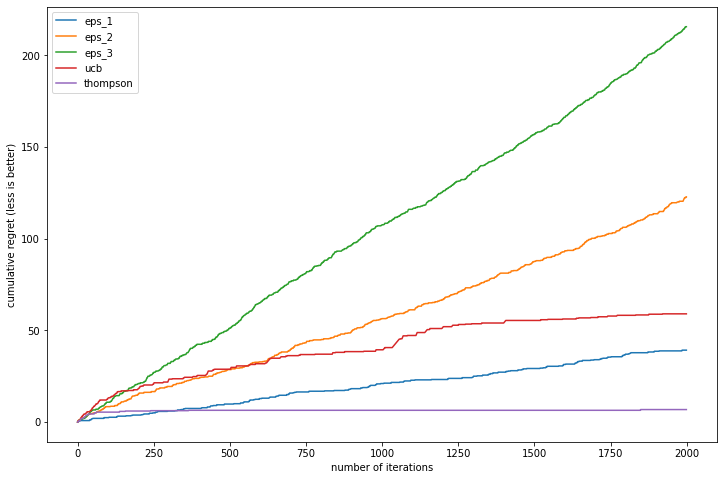

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(eps_regrets, label='eps_1')
plt.plot(eps_2_regrets, label='eps_2')
plt.plot(eps_3_regrets, label='eps_3')
plt.plot(ucb_regrets, label='ucb')
plt.plot(tompson_regrets, label='thompson')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('cumulative regret (less is better)')